In [1]:
import os
import PATH
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
import torch
import utils
import copy

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.metrics import r2_score
from tqdm import tqdm
from models import reader
from models.popen import Auto_popen

add /ssd/users/wergillius/Project/MTtrans to path
/ssd/users/wergillius/Project/MTtrans


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
pj = lambda x: os.path.join(utils.script_dir, x)
dpj = lambda x: os.path.join(utils.data_dir, x)

# define some function

In [17]:
def kfold_load_data(config_file, device, kfold_index):
    loader_set = {}                                                                                                                                                                                                                                                                                                                 
    base_path = ['cycle_train_val.csv', 'cycle_test.csv']
    base_csv = 'cycle_MTL_transfer.csv'
    POPEN = Auto_popen(pj(config_file))

    for subset in POPEN.cycle_set:
        if (subset in ['MPA_U', 'MPA_H', 'MPA_V', 'SubMPA_H']):
            datapopen = Auto_popen(pj('log/Backbone/RL_hard_share/3M/schedule_lr.ini'))
            datapopen.split_like = [path.replace('cycle', subset) for path in base_path]
            datapopen.kfold_index = kfold_index
            datapopen.shuffle = False
            
        elif (subset in ['RP_293T', 'RP_muscle', 'RP_PC3']):
            datapopen = Auto_popen(pj('log/Backbone/RL_hard_share/3R/schedule_MTL.ini'))
            datapopen.csv_path = base_csv.replace('cycle', subset)
            datapopen.kfold_index = kfold_index
            datapopen.shuffle = False
            

        # in the order of 0: train , 1: val , 2: test
        loader_set[subset] = reader.get_dataloader(datapopen)

    return loader_set

def reload_model(config_file, device, kfold_index):
    
    POPEN  = Auto_popen(pj(config_file))
    if kfold_index is None:
        check_point = torch.load(POPEN.vae_pth_path, map_location=device)
    else:
        check_point = torch.load(
            POPEN.vae_pth_path.replace('.pth', '_cv%d.pth'%kfold_index),
            map_location=device)
        
    model = check_point['state_dict'].to(device)
    return model

def val_a_epoch(model, dataloader, device):
    y_true_ls = []
    y_pred_ls = []
    
    model.eval()
    with torch.no_grad():
        for X,Y in dataloader:
            X = X.float().to(device)
            y_true_ls.append(Y.cpu().numpy())

            y_pred = model(X)
            y_pred_ls.append(y_pred.cpu().numpy())
    
    y_true_f = np.concatenate( y_true_ls).flatten()
    y_pred_f = np.concatenate( y_pred_ls).flatten()
    
    return y_true_f, y_pred_f


In [35]:
def eval_pipeline(config_path , which_set, cv_k_list, device=0):

    POPEN = Auto_popen(pj(config_path))

    r2_dict = {task :[] for task in POPEN.cycle_set}
    spr_dict = {task :[] for task in POPEN.cycle_set}

    for k in cv_k_list:
        
        model_k = reload_model(config_path, device, k)
        loaders = kfold_load_data(config_path,device,k)

        for task in POPEN.cycle_set:
            model_k.task = task
            dataloader = loaders[task][which_set]
            true_N_pred = val_a_epoch(model_k, dataloader, device)

            # compute and then add to dict
            spr_dict[task].append(stats.spearmanr(*true_N_pred)[0])
            r2_dict[task].append(r2_score(*true_N_pred))

    spr_df = pd.DataFrame(spr_dict)
    spr_df.columns = [col+"_spr" for col in spr_df.columns]
    
    r2_df = pd.DataFrame(r2_dict)
    r2_df.columns = [col+"_r2" for col in r2_df.columns]

    result_df = pd.concat([spr_df,r2_df],axis=1)
    melt_df = pd.melt(result_df,value_name='performance')
    melt_df['model'] = POPEN.run_name
    melt_df['task'] = melt_df['variable'].apply(lambda x: x.split("_")[-2])
    melt_df['metric'] = melt_df['variable'].apply(lambda x: x.split("_")[-1])
    melt_df.loc[:,'which_set'] = ['train','val','test'][which_set]
    return melt_df


# 3R

In [36]:
device = torch.device('cuda:0')
config_3R = "log/Backbone/RL_hard_share/3R/schedule_MTL.ini"

df_val_3R = eval_pipeline(config_3R, 1, range(3),device=device)
df_test_3R = eval_pipeline(config_3R, 2, range(3),device=device)

In [42]:
df_test_3R.loc[:,'model'] = '3R'

# single tasks

In [44]:
config_ST293 = "log/Backbone/RL_hard_share/single_task/RP_single_task/ST_293T.ini"

df_test_ST293 = eval_pipeline(config_ST293, 2, range(3),device=device)

In [38]:
config_STmuscle = "log/Backbone/RL_hard_share/single_task/RP_single_task/ST_muscle.ini"

df_test_STmuscle = eval_pipeline(config_STmuscle, 2, range(3),device=device)

In [39]:
config_STPC3 = "log/Backbone/RL_hard_share/single_task/RP_single_task/ST_PC3.ini"

df_test_STPC3 = eval_pipeline(config_STPC3, 2, range(3),device=device)

# visualize

In [56]:
cellline_prediction_df = pd.DataFrame([])

for df in [df_test_3R, df_test_ST293, df_test_STmuscle, df_test_STPC3]:
    cellline_prediction_df=cellline_prediction_df.append(df)

In [64]:
sns.set_theme(style='ticks',palette='Set2',font_scale=1.1)


%matplotlib inline

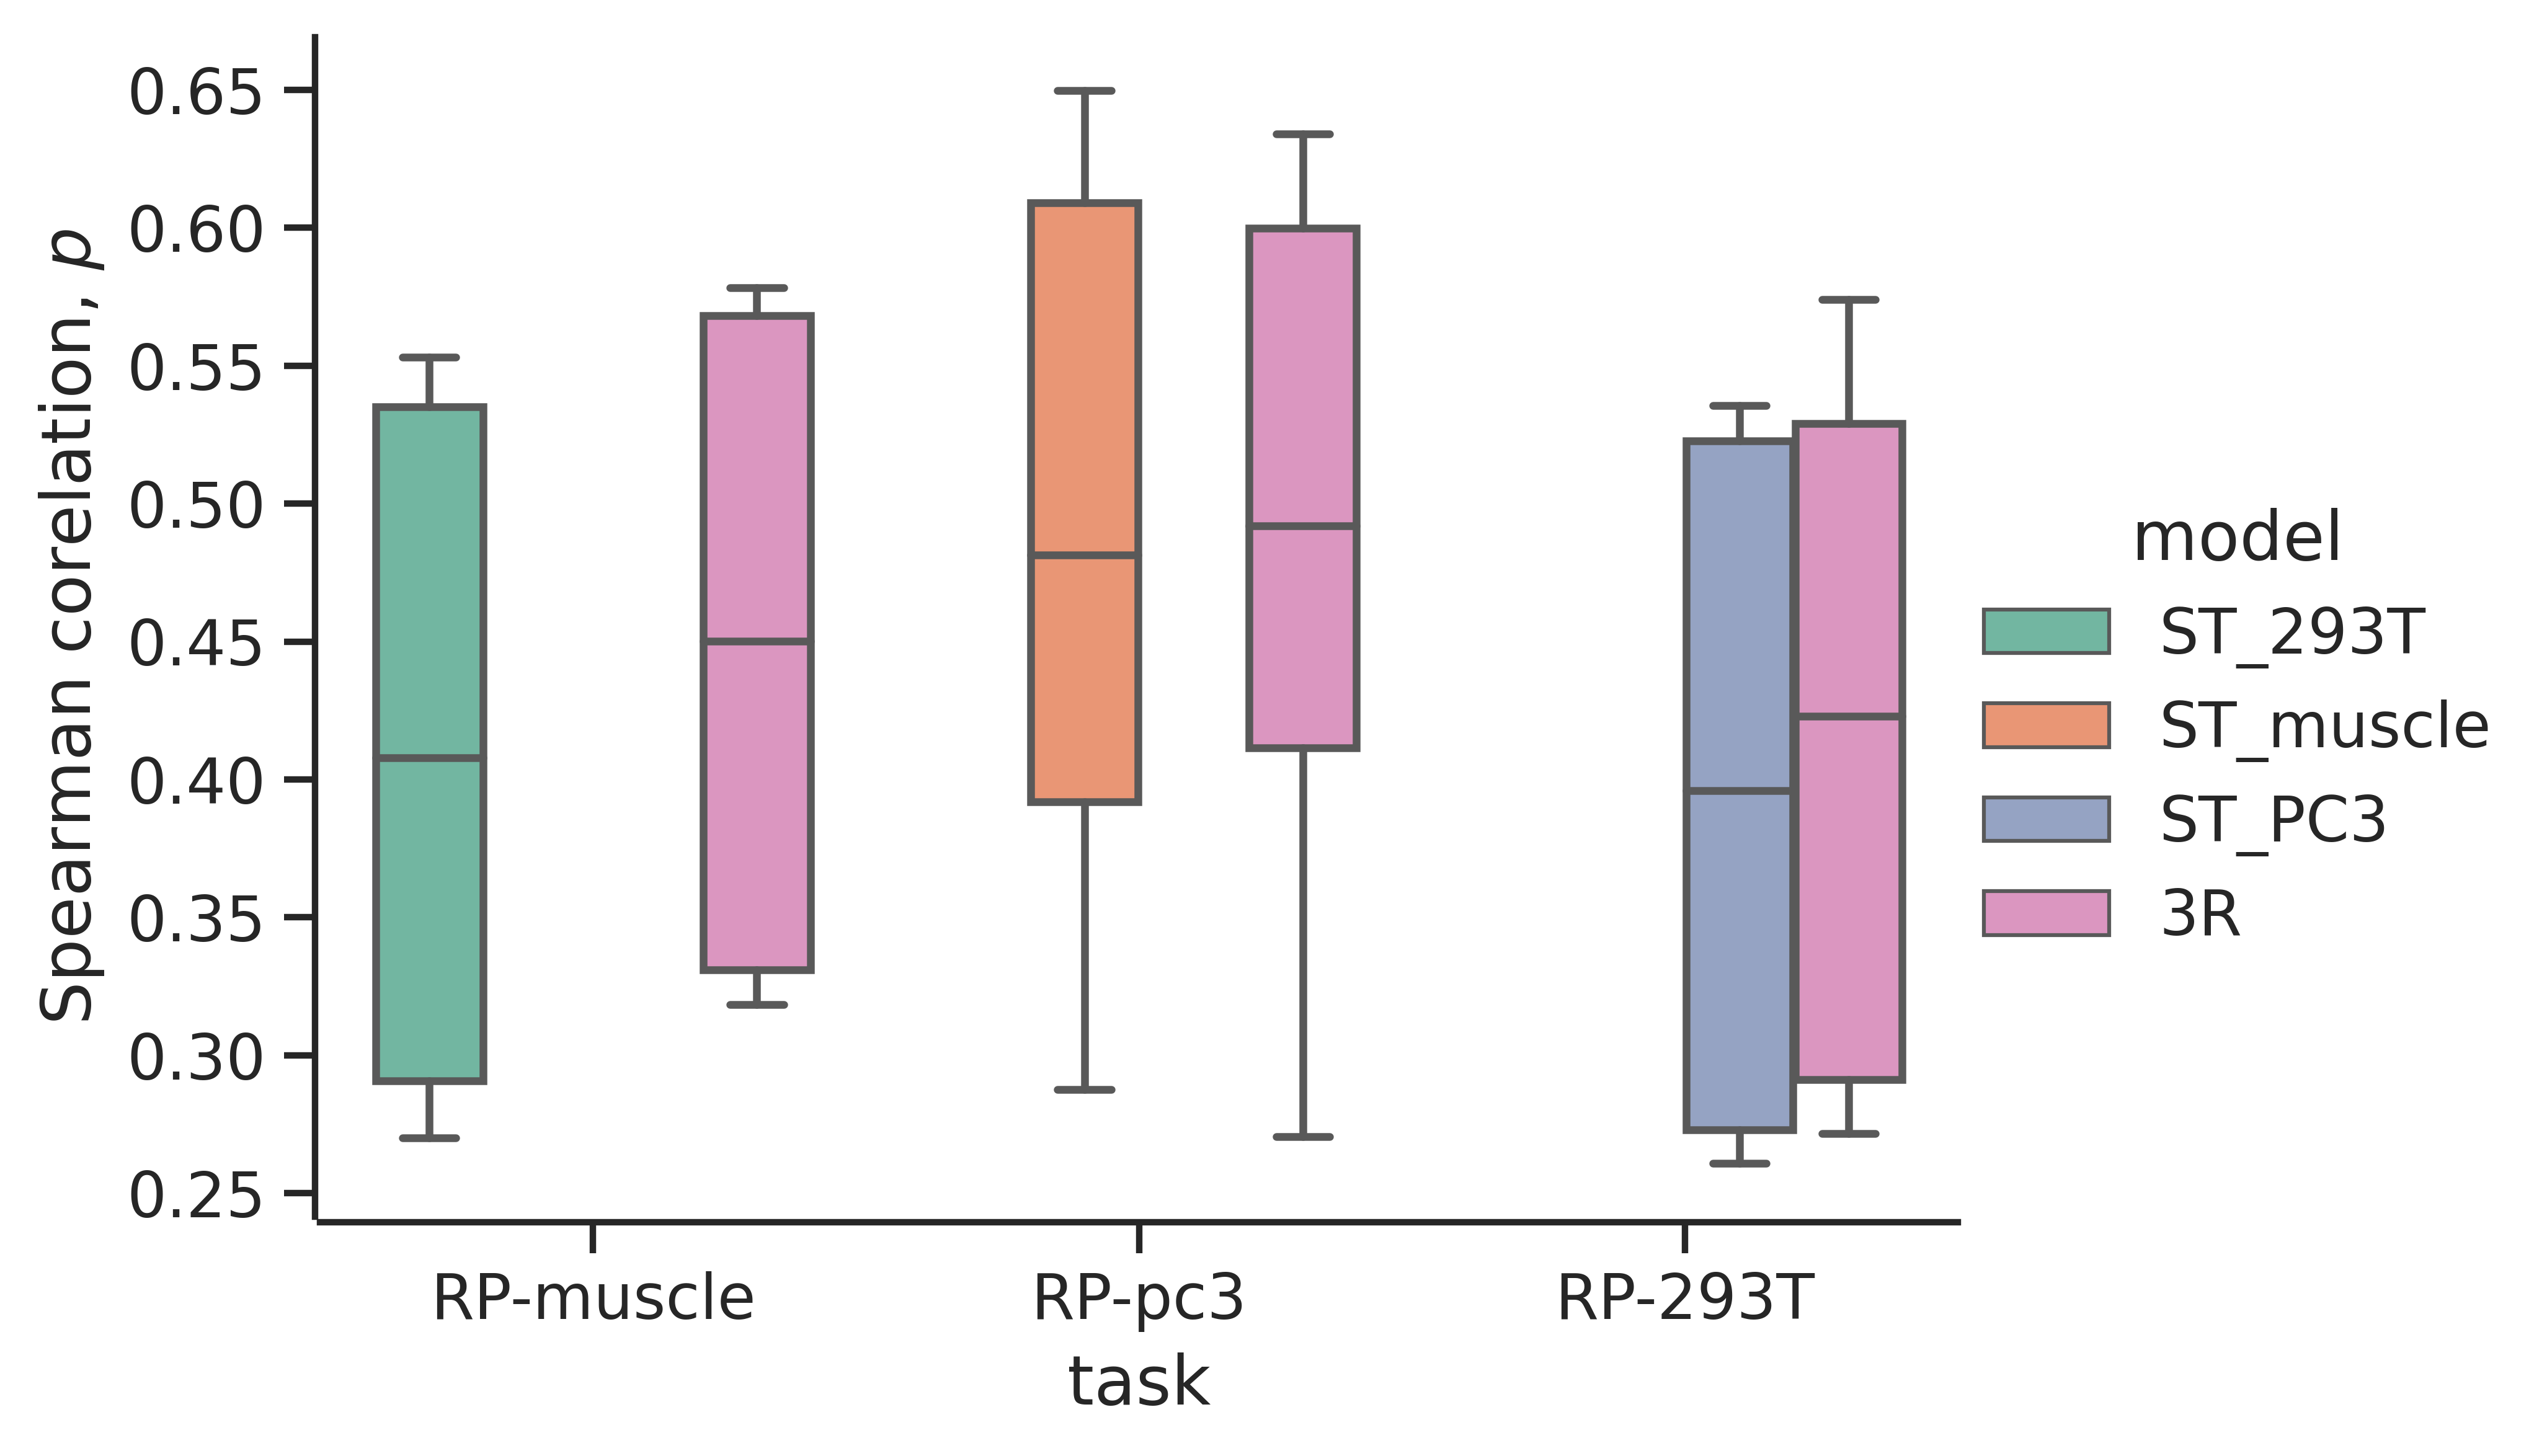

In [70]:
plt.rcParams['figure.dpi'] = 600
g=sns.catplot(data=cellline_prediction_df,x='task',y='performance',
    hue='model', hue_order=['ST_293T','ST_muscle','ST_PC3','3R'],
    kind='box', aspect=1.4, height=4)

    
sns.despine(trim=False, offset=1)
plt.ylabel(r'Spearman corelation, $p$')
plt.xticks([0,1,2],['RP-muscle','RP-pc3','RP-293T']);
